##Data Import

In [ ]:
%pip install mlflow 

Python interpreter will be restarted.
Python interpreter will be restarted.


In [ ]:
import pyspark
import mlflow
from pyspark.sql.functions import isnull, when, count, col
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName('Churn').getOrCreate()

In [ ]:
spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.3.2 
 Master 
 local[8] 
 AppName 
 Databricks Shell

In [ ]:
df = spark.read.csv('/FileStore/tables/train-1.csv', header=True, inferSchema=True)

##Data Exploration

In [ ]:
df.show(5) # Show dataset top 5 rows

+---+----------+--------------+-----------+---------+------+----+------+---------+-------------+---------+--------------+---------------+------+
| id|CustomerId|       Surname|CreditScore|Geography|Gender| Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---+----------+--------------+-----------+---------+------+----+------+---------+-------------+---------+--------------+---------------+------+
|  0|  15674932|Okwudilichukwu|        668|   France|  Male|33.0|     3|      0.0|            2|      1.0|           0.0|      181449.97|     0|
|  1|  15749177| Okwudiliolisa|        627|   France|  Male|33.0|     1|      0.0|            2|      1.0|           1.0|        49503.5|     0|
|  2|  15694510|         Hsueh|        678|   France|  Male|40.0|    10|      0.0|            2|      1.0|           0.0|      184866.69|     0|
|  3|  15741417|           Kao|        581|   France|  Male|34.0|     2|148882.54|            1|      1.0|           1.0|       84

In [ ]:
type(df) #Check type of dataframe

Out[5]: pyspark.sql.dataframe.DataFrame

In [ ]:
df.head(2) # Get top 2 records (Return: List format)

Out[6]: [Row(id=0, CustomerId=15674932, Surname='Okwudilichukwu', CreditScore=668, Geography='France', Gender='Male', Age=33.0, Tenure=3, Balance=0.0, NumOfProducts=2, HasCrCard=1.0, IsActiveMember=0.0, EstimatedSalary=181449.97, Exited=0),
 Row(id=1, CustomerId=15749177, Surname='Okwudiliolisa', CreditScore=627, Geography='France', Gender='Male', Age=33.0, Tenure=1, Balance=0.0, NumOfProducts=2, HasCrCard=1.0, IsActiveMember=1.0, EstimatedSalary=49503.5, Exited=0)]

In [ ]:
df.tail(2) # Get Bottom 2 records

Out[7]: [Row(id=165032, CustomerId=15689614, Surname='Hsiung', CreditScore=554, Geography='Spain', Gender='Female', Age=30.0, Tenure=7, Balance=161533.0, NumOfProducts=1, HasCrCard=0.0, IsActiveMember=1.0, EstimatedSalary=71173.03, Exited=0),
 Row(id=165033, CustomerId=15732798, Surname='Ulyanov', CreditScore=850, Geography='France', Gender='Male', Age=31.0, Tenure=1, Balance=0.0, NumOfProducts=1, HasCrCard=1.0, IsActiveMember=0.0, EstimatedSalary=61581.79, Exited=1)]

In [ ]:
df.printSchema() #Check datatypes of columns

root
 |-- id: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: double (nullable = true)
 |-- IsActiveMember: double (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)



In [ ]:
df.columns #Check columns in the dataset

Out[9]: ['id',
 'CustomerId',
 'Surname',
 'CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited']

In [ ]:
# Select and show a single column
df.select('CreditScore').show(5)

+-----------+
|CreditScore|
+-----------+
|        668|
|        627|
|        678|
|        581|
|        716|
+-----------+
only showing top 5 rows



In [ ]:
# Select and show multiple columns
df.select(['Gender','Age','Tenure']).show(5)

+------+----+------+
|Gender| Age|Tenure|
+------+----+------+
|  Male|33.0|     3|
|  Male|33.0|     1|
|  Male|40.0|    10|
|  Male|34.0|     2|
|  Male|33.0|     5|
+------+----+------+
only showing top 5 rows



In [ ]:
df.dtypes #Check datatypes with dtypes

Out[12]: [('id', 'int'),
 ('CustomerId', 'int'),
 ('Surname', 'string'),
 ('CreditScore', 'int'),
 ('Geography', 'string'),
 ('Gender', 'string'),
 ('Age', 'double'),
 ('Tenure', 'int'),
 ('Balance', 'double'),
 ('NumOfProducts', 'int'),
 ('HasCrCard', 'double'),
 ('IsActiveMember', 'double'),
 ('EstimatedSalary', 'double'),
 ('Exited', 'int')]

In [ ]:
# Get dataset statistics
stats = df.describe()
stats = stats.toPandas()

In [ ]:
print(type(stats)) # Converted stats dataframe to pandas dataframe to display it better

<class 'pandas.core.frame.DataFrame'>


In [ ]:
stats

,summary,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,count,165034,165034,165034,165034,165034,165034,165034,165034,165034,165034,165034,165034,165034,165034
1,mean,82516.5,1.5692005019026382E7,None,656.454373038283,None,None,38.12588787764945,5.020353381727402,55478.086689349235,1.5544554455445545,0.7539537307463916,0.49777015645260975,112574.82273434362,0.21159882206090866
2,stddev,47641.356500069,71397.81679067112,None,80.1033404871783,None,None,8.867204591410792,2.8061585665860913,62817.66327783688,0.5471536788441764,0.4307071240449495,0.49999654260421705,50292.865584904175,0.4084431067117287
3,min,0,15565701,Abazu,350,France,Female,18.0,0,0.0,1,0.0,0.0,11.58,0
4,max,165033,15815690,Zuyeva,850,Spain,Male,92.0,10,250898.09,4,1.0,1.0,199992.48,1


### Data Description

* **Customer ID**: A unique identifier for each customer
* **Surname**: The customer's surname or last name
* **Credit Score**: A numerical value representing the customer's credit score
* **Geography**: The country where the customer resides
* **Gender**: The customer's gender
* **Age**: The customer's age.
* **Tenure**: The number of years the customer has been with the bank
* **Balance**: The customer's account balance
* **NumOfProducts**: The number of bank products the customer uses (e.g., savings account, credit card)
* **HasCrCard**: Whether the customer has a credit card
* **IsActiveMember**: Whether the customer is an active member
* **EstimatedSalary**: The estimated salary of the customer
* **Exited**: Whether the customer has churned (Target Variable)

##EDA

In [ ]:
# Lets rename exited, our target Exited to Churned
df = df.withColumnRenamed('Exited','Churned')
df.show(5)

+---+----------+--------------+-----------+---------+------+----+------+---------+-------------+---------+--------------+---------------+-------+
| id|CustomerId|       Surname|CreditScore|Geography|Gender| Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Churned|
+---+----------+--------------+-----------+---------+------+----+------+---------+-------------+---------+--------------+---------------+-------+
|  0|  15674932|Okwudilichukwu|        668|   France|  Male|33.0|     3|      0.0|            2|      1.0|           0.0|      181449.97|      0|
|  1|  15749177| Okwudiliolisa|        627|   France|  Male|33.0|     1|      0.0|            2|      1.0|           1.0|        49503.5|      0|
|  2|  15694510|         Hsueh|        678|   France|  Male|40.0|    10|      0.0|            2|      1.0|           0.0|      184866.69|      0|
|  3|  15741417|           Kao|        581|   France|  Male|34.0|     2|148882.54|            1|      1.0|           1.0|   

In [ ]:
# Checking target variable values
df.select('Churned').distinct().show()

+-------+
|Churned|
+-------+
|      1|
|      0|
+-------+



In [ ]:
# Lets check for null columns
df.select([count(when(isnull(c),c)).alias(c) for c in df.columns]).show()

+---+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+-------+
| id|CustomerId|Surname|CreditScore|Geography|Gender|Age|Tenure|Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Churned|
+---+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+-------+
|  0|         0|      0|          0|        0|     0|  0|     0|      0|            0|        0|             0|              0|      0|
+---+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+-------+



In [ ]:
# Lets check for duplicates
if df.count()>df.dropDuplicates([c for c in df.columns]).count():
    raise ValueError("Data has duplicates")
else:
    print('No duplicates found')

No duplicates found


In [ ]:
# Data has no duplicates and null values hence no need to impute or drop them
# Lets check and drop irrelevant columns
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: double (nullable = true)
 |-- IsActiveMember: double (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Churned: integer (nullable = true)



In [ ]:
# Lets drop id, CustomerId and Surname as they are irrelevant features that dont add any value
df = df.drop('id','CustomerId','Surname')

In [ ]:
df.show(5)

+-----------+---------+------+----+------+---------+-------------+---------+--------------+---------------+-------+
|CreditScore|Geography|Gender| Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Churned|
+-----------+---------+------+----+------+---------+-------------+---------+--------------+---------------+-------+
|        668|   France|  Male|33.0|     3|      0.0|            2|      1.0|           0.0|      181449.97|      0|
|        627|   France|  Male|33.0|     1|      0.0|            2|      1.0|           1.0|        49503.5|      0|
|        678|   France|  Male|40.0|    10|      0.0|            2|      1.0|           0.0|      184866.69|      0|
|        581|   France|  Male|34.0|     2|148882.54|            1|      1.0|           1.0|       84560.88|      0|
|        716|    Spain|  Male|33.0|     5|      0.0|            2|      1.0|           1.0|       15068.83|      0|
+-----------+---------+------+----+------+---------+-------------+------

In [ ]:
df.printSchema()

root
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: double (nullable = true)
 |-- IsActiveMember: double (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Churned: integer (nullable = true)



In [ ]:
# Lets encode the string features Geography, and Gender through one-hot encoding
# Lets first check the distinct values before encoding them
df.select('Geography').distinct().show()

+---------+
|Geography|
+---------+
|  Germany|
|   France|
|    Spain|
+---------+



In [ ]:
# Same for gender
df.select('Gender').distinct().show()

+------+
|Gender|
+------+
|Female|
|  Male|
+------+



##Feature Engineering

In [ ]:
# Lets use one-hot-encoding (Not ordinal as there is no ordered relation between the feature values)
# However the columns are made up of strings hence we need to encode them with the string indexer then follow up with a ohe
se = StringIndexer(inputCols = ['Geography','Gender'], outputCols = ['Geography_se', 'Gender_se'])
ohe = OneHotEncoder(inputCols = ['Geography_se','Gender_se'], outputCols = ['Geography_ohe', 'Gender_ohe'])
encode_pipe = Pipeline(stages = [se, ohe])
df = encode_pipe.fit(df).transform(df)
df.show(5)

+-----------+---------+------+----+------+---------+-------------+---------+--------------+---------------+-------+------------+---------+-------------+-------------+
|CreditScore|Geography|Gender| Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Churned|Geography_se|Gender_se|Geography_ohe|   Gender_ohe|
+-----------+---------+------+----+------+---------+-------------+---------+--------------+---------------+-------+------------+---------+-------------+-------------+
|        668|   France|  Male|33.0|     3|      0.0|            2|      1.0|           0.0|      181449.97|      0|         0.0|      0.0|(2,[0],[1.0])|(1,[0],[1.0])|
|        627|   France|  Male|33.0|     1|      0.0|            2|      1.0|           1.0|        49503.5|      0|         0.0|      0.0|(2,[0],[1.0])|(1,[0],[1.0])|
|        678|   France|  Male|40.0|    10|      0.0|            2|      1.0|           0.0|      184866.69|      0|         0.0|      0.0|(2,[0],[1.0])|(1,[0],[1.0])

In [ ]:
# We will not normalize the data as we will make use of a gradient boosted tree. For GBT branching is done on basis of actual values, hence we dont require
# any data normalization
# We need to use the vector assembler to create the feature set and traget variable
feature_assembler = VectorAssembler(inputCols = ['CreditScore', 'Geography_ohe', 'Gender_ohe', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], outputCol = 'IndependentFeatures')
df = feature_assembler.transform(df)

In [ ]:
df.show(5)

+-----------+---------+------+----+------+---------+-------------+---------+--------------+---------------+-------+------------+---------+-------------+-------------+--------------------+
|CreditScore|Geography|Gender| Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Churned|Geography_se|Gender_se|Geography_ohe|   Gender_ohe| IndependentFeatures|
+-----------+---------+------+----+------+---------+-------------+---------+--------------+---------------+-------+------------+---------+-------------+-------------+--------------------+
|        668|   France|  Male|33.0|     3|      0.0|            2|      1.0|           0.0|      181449.97|      0|         0.0|      0.0|(2,[0],[1.0])|(1,[0],[1.0])|[668.0,1.0,0.0,1....|
|        627|   France|  Male|33.0|     1|      0.0|            2|      1.0|           1.0|        49503.5|      0|         0.0|      0.0|(2,[0],[1.0])|(1,[0],[1.0])|[627.0,1.0,0.0,1....|
|        678|   France|  Male|40.0|    10|      0.0|        

In [ ]:
df.printSchema()

root
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: double (nullable = true)
 |-- IsActiveMember: double (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Churned: integer (nullable = true)
 |-- Geography_se: double (nullable = false)
 |-- Gender_se: double (nullable = false)
 |-- Geography_ohe: vector (nullable = true)
 |-- Gender_ohe: vector (nullable = true)
 |-- IndependentFeatures: vector (nullable = true)



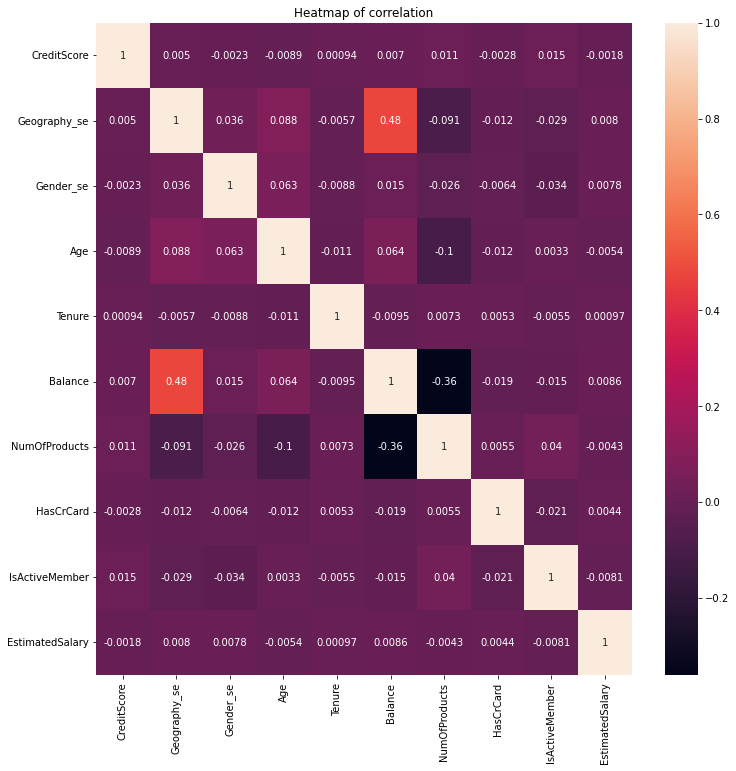

In [ ]:
plt.figure(figsize=(12, 12))
plt.title('Heatmap of correlation')
dfCorr = df.select(*['CreditScore', 'Geography_se', 'Gender_se', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']) 
sns.heatmap(dfCorr.toPandas().corr(), annot=True)
plt.show()

In [ ]:
# Balance and geography have a high correlation of 0.48. We will can perform an ablation study of training model with and without one of these two variables and with both of them and see the test metrics accordingly.

In [ ]:
# lets select our features and target to create our final df
df_final = df.select('IndependentFeatures','Churned')

In [ ]:
df_final.show(5)

+--------------------+-------+
| IndependentFeatures|Churned|
+--------------------+-------+
|[668.0,1.0,0.0,1....|      0|
|[627.0,1.0,0.0,1....|      0|
|[678.0,1.0,0.0,1....|      0|
|[581.0,1.0,0.0,1....|      0|
|[716.0,0.0,1.0,1....|      0|
+--------------------+-------+
only showing top 5 rows



In [ ]:
df_final.count()

Out[34]: 165034